In [1]:
# Importing necessary libraries and modules

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
import numpy as np
from scipy.spatial import distance

import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import (
    resnet34,
    ResNet34_Weights,
    resnet18,
    ResNet18_Weights,
    vgg11,
    VGG11_Weights,
)

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tqdm.notebook import tqdm
import seaborn as sb

from copy import deepcopy

# Set seaborn theme
sb.set_theme()

In [2]:
# Check if CUDA is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Load Data

In [3]:
# Define a series of transformations to apply to an image.

transform = transforms.Compose(
    [
        transforms.Resize(size=256),  # Resize the image to 256x256 pixels.
        transforms.CenterCrop(
            size=224
        ),  # Crop the center of the image to 224x224 pixels.
        transforms.ToTensor(),  # Convert the image to a tensor.
        transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        ),  # Normalize the image with mean and standard deviation.
    ]
)

In [4]:
# Load the training data
train_data = datasets.CIFAR10("data", train=True, download=True, transform=transform)

# Load the test data
test_data = datasets.CIFAR10("data", train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 47548240.93it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
# Split the training data into training and validation subsets
train_subset, val_subset = torch.utils.data.random_split(
    train_data, [0.85, 0.15], generator=torch.Generator().manual_seed(1)
)

### Dense (Fully Connected) Layer

In [6]:
class Dense:
    def __init__(self, n_inputs, n_neurons):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

        # Initialize the weights with random values based on normal distribution with He heuristic
        self.weights = (
            torch.randn(n_inputs, n_neurons) * torch.sqrt(torch.tensor(2.0 / n_inputs))
        ).to(device)
        # Initialize the biases with zeros
        self.biases = torch.zeros(1, n_neurons).to(device)

    def forward(self, inputs):
        self.inputs = inputs
        self.output = torch.matmul(self.inputs, self.weights) + self.biases

    def backward(self, b_input):
        self.weights_gradient = torch.matmul(self.inputs.T, b_input)
        self.biases_gradient = torch.sum(b_input, dim=0, keepdims=True)
        self.inputs_gradient = torch.matmul(b_input, self.weights.T)

        self.b_output = self.inputs_gradient

### Activation Functions

In [7]:
class ReLU:
    def __repr__(self):
        return "ReLU"

    def forward(self, inputs):
        # Calculate the output using the ReLU activation function
        self.output = torch.maximum(torch.zeros(inputs.size()).to(device), inputs)

    def backward(self, b_input):
        inputs_gradient = b_input.clone()
        # Set the gradient to zero where the output is less than or equal to zero
        inputs_gradient[self.output <= 0] = 0
        self.b_output = inputs_gradient

In [8]:
class Sigmoid:
    def __repr__(self):
        return "Sigmoid"

    def forward(self, inputs):
        # Calculate the sigmoid function of the input tensor
        self.output = 1 / (1 + torch.exp(-inputs))

    def backward(self, b_input):
        inputs_gradient = b_input * (1 - self.output) * self.output
        self.b_output = inputs_gradient

### Loss Function

In [9]:
class Categorical_Cross_Entropy_loss_Softmax:
    def forward(self, inputs, batch_size, class_label=None):
        max_out, max_inds = torch.max(inputs, dim=1, keepdims=True)

        # Calculate the exponential values
        exp_vals = torch.exp(inputs - max_out)

        # Calculate the softmax values
        self.softmax = exp_vals / torch.sum(exp_vals, dim=1, keepdims=True)
        self.softmax += 1e-7  # Add a small value to avoid division by zero

        # Calculate the loss
        if class_label is not None:
            self.class_label = class_label
            self.batch_size = batch_size
            self.loss = -torch.sum(self.class_label * torch.log(self.softmax))

    def backward(self):
        # Calculate the gradient of the inputs
        self.b_output = (self.softmax - self.class_label) / self.batch_size

### Optimizer

In [10]:
class SGD:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def update(self, layer):
        layer.weights -= (
            self.learning_rate * layer.weights_gradient
        )  # Update the weights
        layer.biases -= self.learning_rate * layer.biases_gradient  # Update the biases

### Architecture

#### Features Extractor

In [11]:
class ResNet34:
    def __init__(self):
        # Load the ResNet34 model with default weights
        self.resnet34 = resnet34(weights=ResNet34_Weights.DEFAULT)
        modules = list(self.resnet34.children())[:-1]

        # Create a new model with all the layers except the last one
        self.resnet34 = torch.nn.Sequential(*modules)

        self.resnet34.eval()  # Set the model to evaluation mode

        self.resnet34 = self.resnet34.to(device)

    def __repr__(self):
        return "ResNet34"

    def get_features(self, images):
        with torch.no_grad():
            # Get the features from the features extractor model
            features = self.resnet34(images)
        return features

    def get_size(self):
        with torch.no_grad():
            features = torch.flatten(
                self.resnet34(torch.zeros(1, 3, 224, 224).to(device)), start_dim=1
            )
        # Return the size of the features
        return features.shape

In [12]:
class ResNet18:
    def __init__(self):
        # Load the ResNet18 model with default weights
        self.resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)
        modules = list(self.resnet18.children())[:-1]

        # Create a new model with all the layers except the last one
        self.resnet18 = torch.nn.Sequential(*modules)

        self.resnet18.eval()  # Set the model to evaluation mode

        self.resnet18 = self.resnet18.to(device)

    def __repr__(self):
        return "ResNet18"

    def get_features(self, images):
        with torch.no_grad():
            # Get the features from the features extractor model
            features = self.resnet18(images)
        return features

    def get_size(self):
        with torch.no_grad():
            features = torch.flatten(
                self.resnet18(torch.zeros(1, 3, 224, 224).to(device)), start_dim=1
            )
        # Return the size of the features
        return features.shape

In [13]:
class VGG11:
    def __init__(self):
        # Load the VGG11 model with default weights
        self.vgg11 = vgg11(weights=VGG11_Weights.DEFAULT)
        modules = list(self.vgg11.children())[:-1]

        # Create a new model with all the layers except the last one
        self.vgg11 = torch.nn.Sequential(*modules)

        self.vgg11.eval()  # Set the model to evaluation mode

        self.vgg11 = self.vgg11.to(device)

    def __repr__(self):
        return "VGG11"

    def get_features(self, images):
        with torch.no_grad():
            # Get the features from the features extractor model
            features = self.vgg11(images)
        return features

    def get_size(self):
        with torch.no_grad():
            features = torch.flatten(
                self.vgg11(torch.zeros(1, 3, 224, 224).to(device)), start_dim=1
            )
        # Return the size of the features
        return features.shape

In [14]:
fe_resnet18 = ResNet18()
fe_resnet34 = ResNet34()
fe_vgg11 = VGG11()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 73.4MB/s]
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:06<00:00, 76.0MB/s]


#### Neural Network

In [15]:
class AKModel:
    def __init__(
        self,
        features_extractor=fe_resnet34,
        number_of_classes=10,
        batch_size=32,
        tune=False,
    ):
        self.batch_size = batch_size
        self.number_of_classes = number_of_classes

        self.optimizer = SGD(learning_rate=0.001)
        self.features_extractor = features_extractor
        self.n_inputs = self.features_extractor.get_size()[1]

        if not tune:
            self.layers = [Dense(self.n_inputs, 20), Dense(20, self.number_of_classes)]
            self.activations = [ReLU(), Categorical_Cross_Entropy_loss_Softmax()]

        # Create a data loader for the training data
        self.train_loader = torch.utils.data.DataLoader(
            dataset=train_subset, shuffle=True, batch_size=self.batch_size
        )

        # Create a data loader for the validation data
        self.val_loader = torch.utils.data.DataLoader(
            dataset=val_subset, shuffle=False, batch_size=self.batch_size
        )

        # Create a data loader for the test data
        self.test_loader = torch.utils.data.DataLoader(
            dataset=test_data, shuffle=False, batch_size=self.batch_size
        )

    def _forward_propagation(self, data, y_1hot=None):
        """
        This function performs forward propagation on a neural network.
        It takes as input a data tensor and an one-hot encoded label tensor.
        """
        if len(self.activations) != len(self.layers):
            raise Exception(
                "The number of activations should be equal to the number of layers"
            )

        inputs = torch.flatten(self.features_extractor.get_features(data), start_dim=1)
        for layer, activation in zip(self.layers, self.activations):
            layer.forward(inputs)
            if activation == self.activations[-1]:
                activation.forward(layer.output, self.batch_size, y_1hot)
                break
            else:
                activation.forward(layer.output)
            inputs = activation.output

    def _test_val(self):
        acc_hist = []
        loss_hist = []
        for data, label in self.val_loader:
            data = data.to(device)
            label = label.to(device)
            y_1hot = torch.nn.functional.one_hot(
                label, num_classes=self.number_of_classes
            )

            self._forward_propagation(data, y_1hot)

            # Calculate the accuracy
            y_predict = torch.argmax(self.activations[-1].softmax, dim=1)
            accuracy = torch.mean((torch.argmax(y_1hot, dim=1) == y_predict).float())
            acc_hist.append(accuracy)

            # Calculate the loss
            loss = self.activations[-1].loss
            loss_hist.append(loss)

        return torch.mean(torch.Tensor(loss_hist)), torch.mean(torch.Tensor(acc_hist))

    def evaluate(self, train=False):
        if train:
            y_true = []
            y_predict = []

            for data, label in self.train_loader:
                data = data.to(device)
                label = label.to(device)
                y_1hot = torch.nn.functional.one_hot(
                    label, num_classes=self.number_of_classes
                )

                self._forward_propagation(data, y_1hot)

                y_pred = torch.argmax(self.activations[-1].softmax, dim=1)

                for yt, yp in zip(torch.argmax(y_1hot, dim=1), y_pred):
                    y_true.append(yt.item())
                    y_predict.append(yp.item())

            return (
                accuracy_score(y_true, y_predict),
                f1_score(y_true, y_predict, average="weighted"),
            )

        else:
            y_true = []
            y_predict = []

            for data, label in self.test_loader:
                data = data.to(device)
                label = label.to(device)
                y_1hot = torch.nn.functional.one_hot(
                    label, num_classes=self.number_of_classes
                )

                self._forward_propagation(data, y_1hot)

                y_pred = torch.argmax(self.activations[-1].softmax, dim=1)

                for yt, yp in zip(torch.argmax(y_1hot, dim=1), y_pred):
                    y_true.append(yt.item())
                    y_predict.append(yp.item())

            return (
                accuracy_score(y_true, y_predict),
                f1_score(y_true, y_predict, average="weighted"),
            )

    def predict(self, data):
        data = data.to(device)

        self._forward_propagation(data)

        y_predict = torch.argmax(self.activations[-1].softmax, dim=1)
        return y_predict

    def train(self, epochs=20, disable_tqdm=False):
        self.epochs = epochs

        self.train_loss_history = []
        self.val_loss_history = []

        self.train_acc_history = []
        self.val_acc_history = []

        for epoch in range(epochs):
            with tqdm(self.train_loader, unit="batch", disable=disable_tqdm) as tepoch:
                # Initialize the history lists for each epoch
                acc_hist = []
                loss_hist = []
                for data, label in tepoch:
                    tepoch.set_description(f"Epoch {epoch + 1}")

                    # Transfer the data to the GPU
                    data = data.to(device)
                    label = label.to(device)

                    # Convert the labels to one-hot encoded vectors
                    y_1hot = torch.nn.functional.one_hot(
                        label, num_classes=self.number_of_classes
                    )

                    self._forward_propagation(data, y_1hot)

                    # Calculate the accuracy
                    y_predict = torch.argmax(self.activations[-1].softmax, dim=1)
                    accuracy = torch.mean(
                        (torch.argmax(y_1hot, dim=1) == y_predict).float()
                    )
                    acc_hist.append(accuracy)

                    # Calculate the loss
                    loss = self.activations[-1].loss
                    loss_hist.append(loss)

                    # Backward propagation
                    self.activations[-1].backward()
                    b_input = self.activations[-1].b_output
                    for layer, activation in zip(
                        reversed(self.layers), reversed(self.activations[:-1])
                    ):
                        layer.backward(b_input)
                        activation.backward(layer.b_output)
                        b_input = activation.b_output
                    self.layers[0].backward(b_input)

                    # Update the weights and biases
                    for layer in self.layers:
                        self.optimizer.update(layer)

                    tepoch.set_postfix(
                        loss=loss.item(), accuracy=f"{accuracy.item()*100:.2f}%"
                    )

            # Calculate the validation loss and accuracy
            val_loss, val_acc = self._test_val()

            # Append the history lists
            self.train_loss_history.append(torch.mean(torch.Tensor(loss_hist)))
            self.val_loss_history.append(val_loss)

            self.train_acc_history.append(torch.mean(torch.Tensor(acc_hist)) * 100)
            self.val_acc_history.append(val_acc * 100)

            # Print the results
            if not disable_tqdm:
                print(f"Epoch:{epoch+1}")
                print(f"Training Loss: {self.train_loss_history[-1]}")
                print(f"Validation Loss: {self.val_loss_history[-1]}")
                print(f"Training Accuracy: {self.train_acc_history[-1]:.2f}%")
                print(f"Validation Accuracy: {self.val_acc_history[-1]:.2f}%")
                print("--------------------------------------------------")

    def plot_losses_and_accuracy(self):
        x_range = range(1, self.epochs + 1)

        plt.figure(figsize=(15, 10))
        plt.xticks(x_range)
        plt.plot(
            x_range, self.train_acc_history, label="Training Accuracy", color="blue"
        )
        plt.plot(
            x_range, self.val_acc_history, label="Validation Accuracy", color="red"
        )
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.gca().xaxis.set_major_locator(MultipleLocator(1))
        plt.xlim([1, self.epochs])
        plt.savefig("Accuracy.png")
        plt.show()

        plt.figure(figsize=(15, 10))
        plt.xticks(x_range)
        plt.plot(x_range, self.train_loss_history, label="Training Loss", color="blue")
        plt.plot(x_range, self.val_loss_history, label="Validation Loss", color="red")
        plt.legend()
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.gca().xaxis.set_major_locator(MultipleLocator(1))
        plt.xlim([1, self.epochs])
        plt.savefig("Loss.png")
        plt.show()

    def plot_confusion_matrix(self, train=True):
        sb.color_palette("flare", as_cmap=True)

        if train:
            y_true, y_predict = [], []
            for data, label in self.train_loader:
                data = data.to(device)
                label = label.to(device)

                # Convert the labels to one-hot encoded vectors
                y_1hot = torch.nn.functional.one_hot(
                    label, num_classes=self.number_of_classes
                )

                self._forward_propagation(data, y_1hot)

                # Calculate the predicted labels
                y_pred = torch.argmax(self.activations[-1].softmax, dim=1)

                for yt, yp in zip(torch.argmax(y_1hot, dim=1), y_pred):
                    y_true.append(yt.item())
                    y_predict.append(yp.item())

            # Calculate the confusion matrix
            cm_train = confusion_matrix(y_true, y_predict)
            df = pd.DataFrame(
                cm_train, index=train_data.classes, columns=train_data.classes
            )
            plt.subplots(figsize=(15, 10))
            sb.heatmap(df, annot=True, fmt="g")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix for the training set")
            plt.savefig("confusion_matrix_train.png")
            plt.show()

        else:
            y_true, y_predict = [], []
            for data, label in self.test_loader:
                data = data.to(device)
                label = label.to(device)

                # Convert the labels to one-hot encoded vectors
                y_1hot = torch.nn.functional.one_hot(
                    label, num_classes=self.number_of_classes
                )

                self._forward_propagation(data, y_1hot)

                # Calculate the predicted labels
                y_pred = torch.argmax(self.activations[-1].softmax, dim=1)

                for yt, yp in zip(torch.argmax(y_1hot, dim=1), y_pred):
                    y_true.append(yt.item())
                    y_predict.append(yp.item())

            # Calculate the confusion matrix
            cm_test = confusion_matrix(y_true, y_predict)
            df = pd.DataFrame(
                cm_test, index=test_data.classes, columns=test_data.classes
            )
            plt.subplots(figsize=(15, 10))
            sb.heatmap(df, annot=True, fmt="g")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix for the testing set")
            plt.savefig("confusion_matrix_test.png")
            plt.show()

### Train

In [16]:
model = AKModel(features_extractor=fe_resnet34, batch_size=32)
model.train(epochs=20)

  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:1
Training Loss: 59.9342155456543
Validation Loss: 43.315887451171875
Training Accuracy: 33.07%
Validation Accuracy: 54.35%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:2
Training Loss: 33.31491470336914
Validation Loss: 27.733728408813477
Training Accuracy: 65.58%
Validation Accuracy: 71.48%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:3
Training Loss: 24.296932220458984
Validation Loss: 22.727439880371094
Training Accuracy: 74.94%
Validation Accuracy: 75.90%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:4
Training Loss: 20.584577560424805
Validation Loss: 20.054006576538086
Training Accuracy: 78.70%
Validation Accuracy: 78.28%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:5
Training Loss: 18.470251083374023
Validation Loss: 18.42797088623047
Training Accuracy: 80.71%
Validation Accuracy: 80.13%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:6
Training Loss: 17.081663131713867
Validation Loss: 17.209388732910156
Training Accuracy: 82.04%
Validation Accuracy: 81.36%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:7
Training Loss: 16.117380142211914
Validation Loss: 16.362369537353516
Training Accuracy: 82.89%
Validation Accuracy: 82.30%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:8
Training Loss: 15.373743057250977
Validation Loss: 15.709817886352539
Training Accuracy: 83.67%
Validation Accuracy: 82.99%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:9
Training Loss: 14.802470207214355
Validation Loss: 15.235097885131836
Training Accuracy: 84.19%
Validation Accuracy: 83.60%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:10
Training Loss: 14.327674865722656
Validation Loss: 14.793651580810547
Training Accuracy: 84.78%
Validation Accuracy: 83.85%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:11
Training Loss: 13.92845630645752
Validation Loss: 14.521878242492676
Training Accuracy: 85.11%
Validation Accuracy: 84.15%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:12
Training Loss: 13.61638355255127
Validation Loss: 14.174957275390625
Training Accuracy: 85.48%
Validation Accuracy: 84.73%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:13
Training Loss: 13.326377868652344
Validation Loss: 13.876106262207031
Training Accuracy: 85.72%
Validation Accuracy: 84.94%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:14
Training Loss: 13.074211120605469
Validation Loss: 13.634099960327148
Training Accuracy: 85.90%
Validation Accuracy: 85.15%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:15
Training Loss: 12.864227294921875
Validation Loss: 13.456958770751953
Training Accuracy: 86.10%
Validation Accuracy: 85.20%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:16
Training Loss: 12.645448684692383
Validation Loss: 13.329323768615723
Training Accuracy: 86.46%
Validation Accuracy: 85.39%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:17
Training Loss: 12.476662635803223
Validation Loss: 13.184595108032227
Training Accuracy: 86.55%
Validation Accuracy: 85.63%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:18
Training Loss: 12.302261352539062
Validation Loss: 13.043095588684082
Training Accuracy: 86.82%
Validation Accuracy: 85.76%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:19
Training Loss: 12.157984733581543
Validation Loss: 12.885416984558105
Training Accuracy: 86.89%
Validation Accuracy: 85.86%
--------------------------------------------------


  0%|          | 0/1329 [00:00<?, ?batch/s]

Epoch:20
Training Loss: 12.017431259155273
Validation Loss: 12.734889030456543
Training Accuracy: 87.08%
Validation Accuracy: 86.12%
--------------------------------------------------


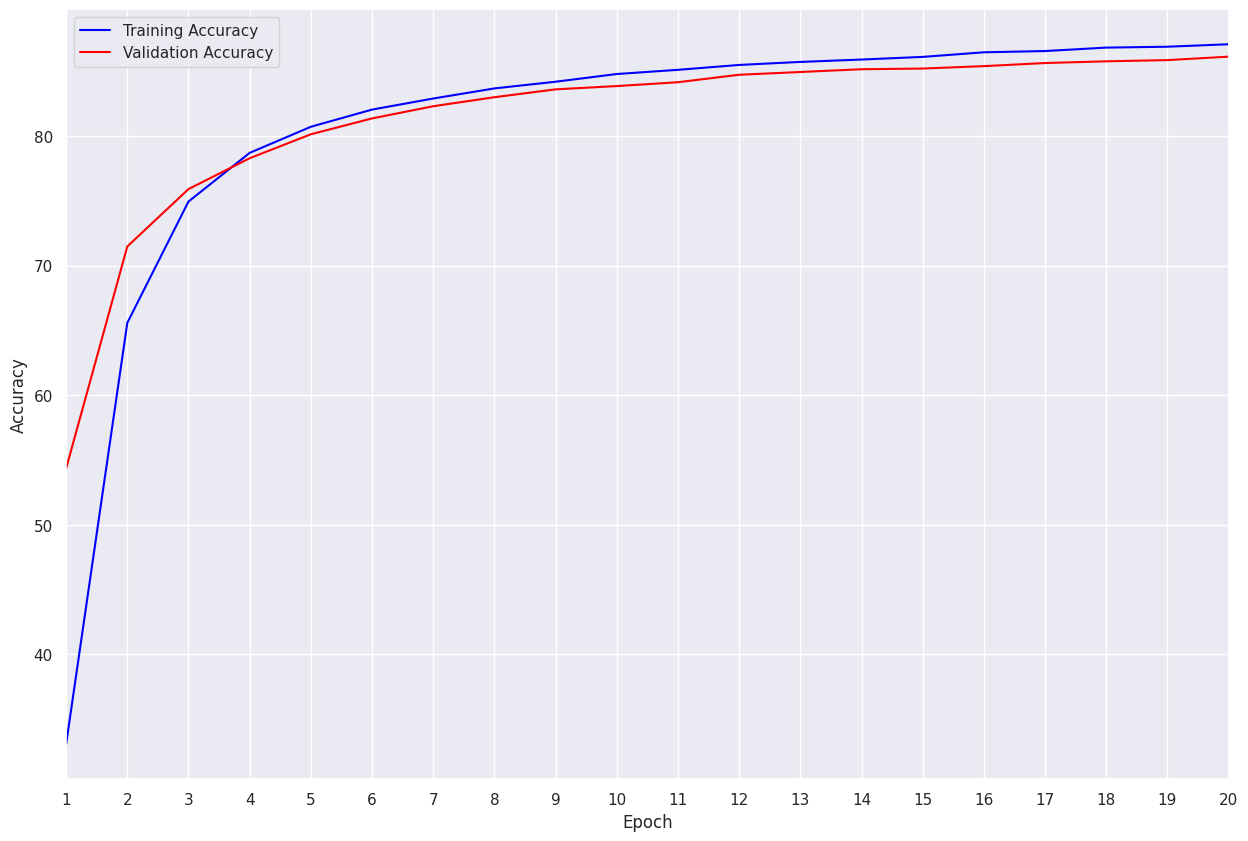

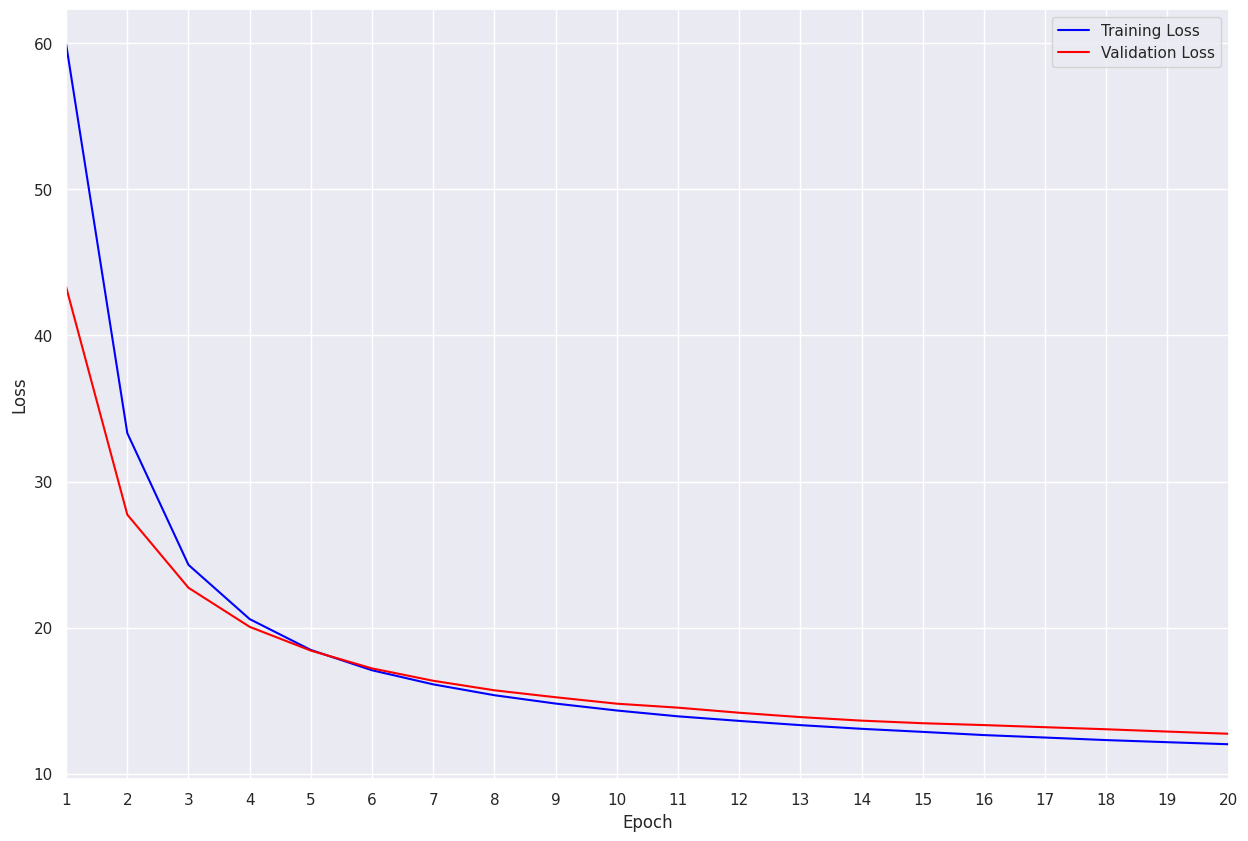

In [17]:
model.plot_losses_and_accuracy()

In [18]:
acc_train, f1_train = model.evaluate(train=True)
print(f"Accuracy score on training set: {acc_train}")
print(f"F1 score on training set: {f1_train}")

Accuracy score on training set: 0.8718823529411764
F1 score on training set: 0.8720614349570488


In [19]:
acc_test, f1_test = model.evaluate(train=False)
print(f"Accuracy score on testing set: {acc_test}")
print(f"F1 score on testing set: {f1_test}")

Accuracy score on testing set: 0.8603
F1 score on testing set: 0.8603208852115515


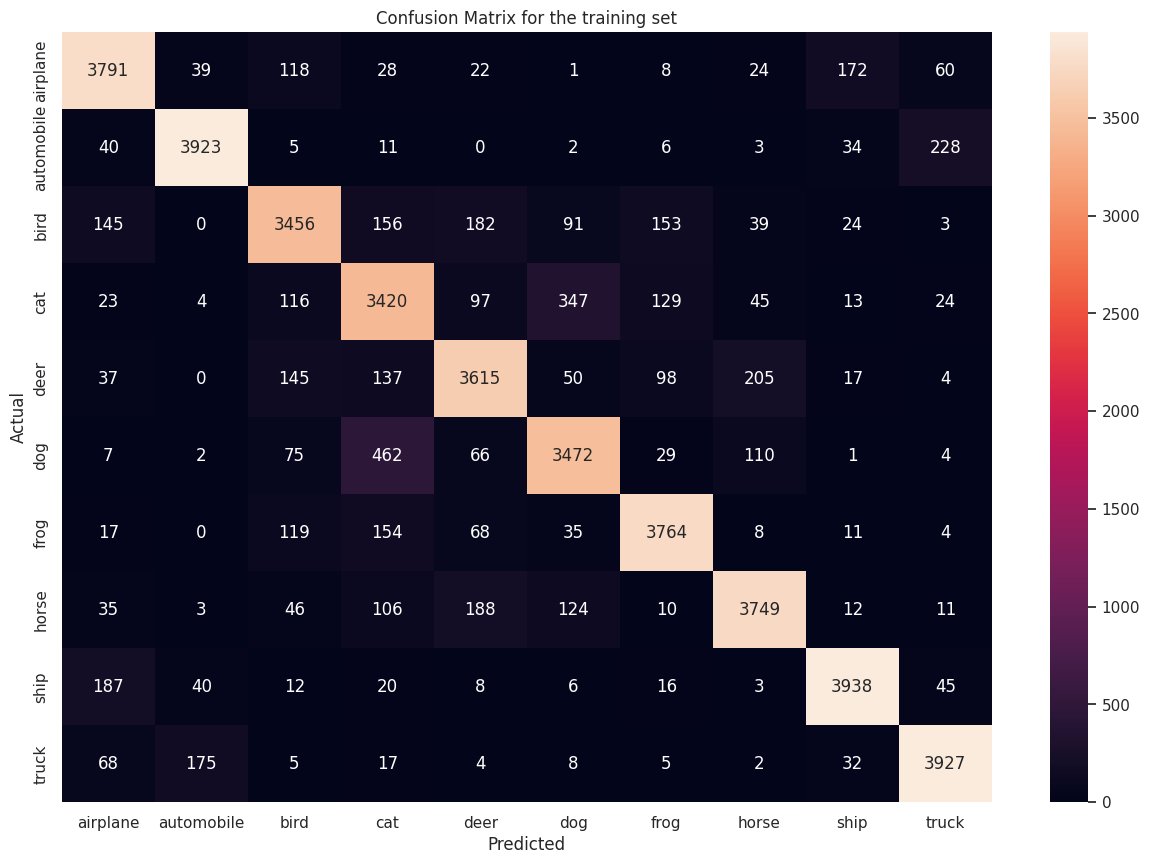

In [20]:
model.plot_confusion_matrix(train=True)

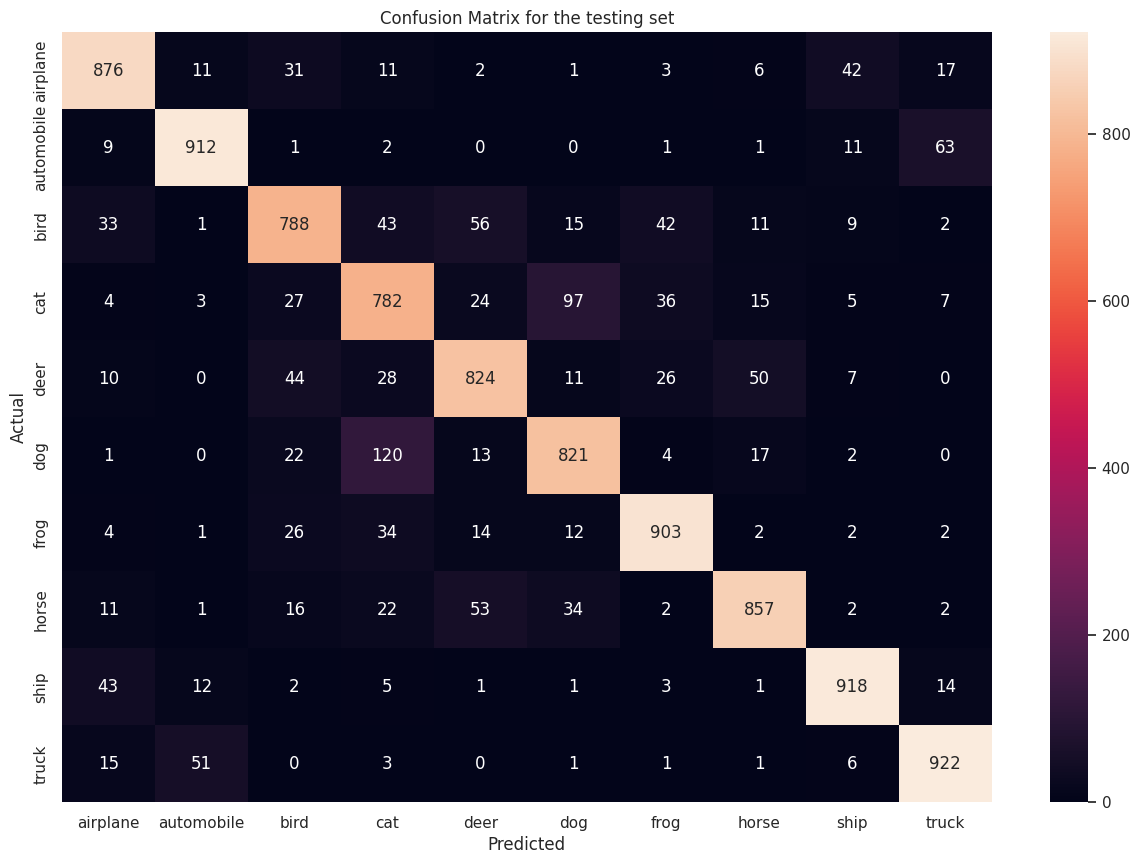

In [21]:
model.plot_confusion_matrix(train=False)

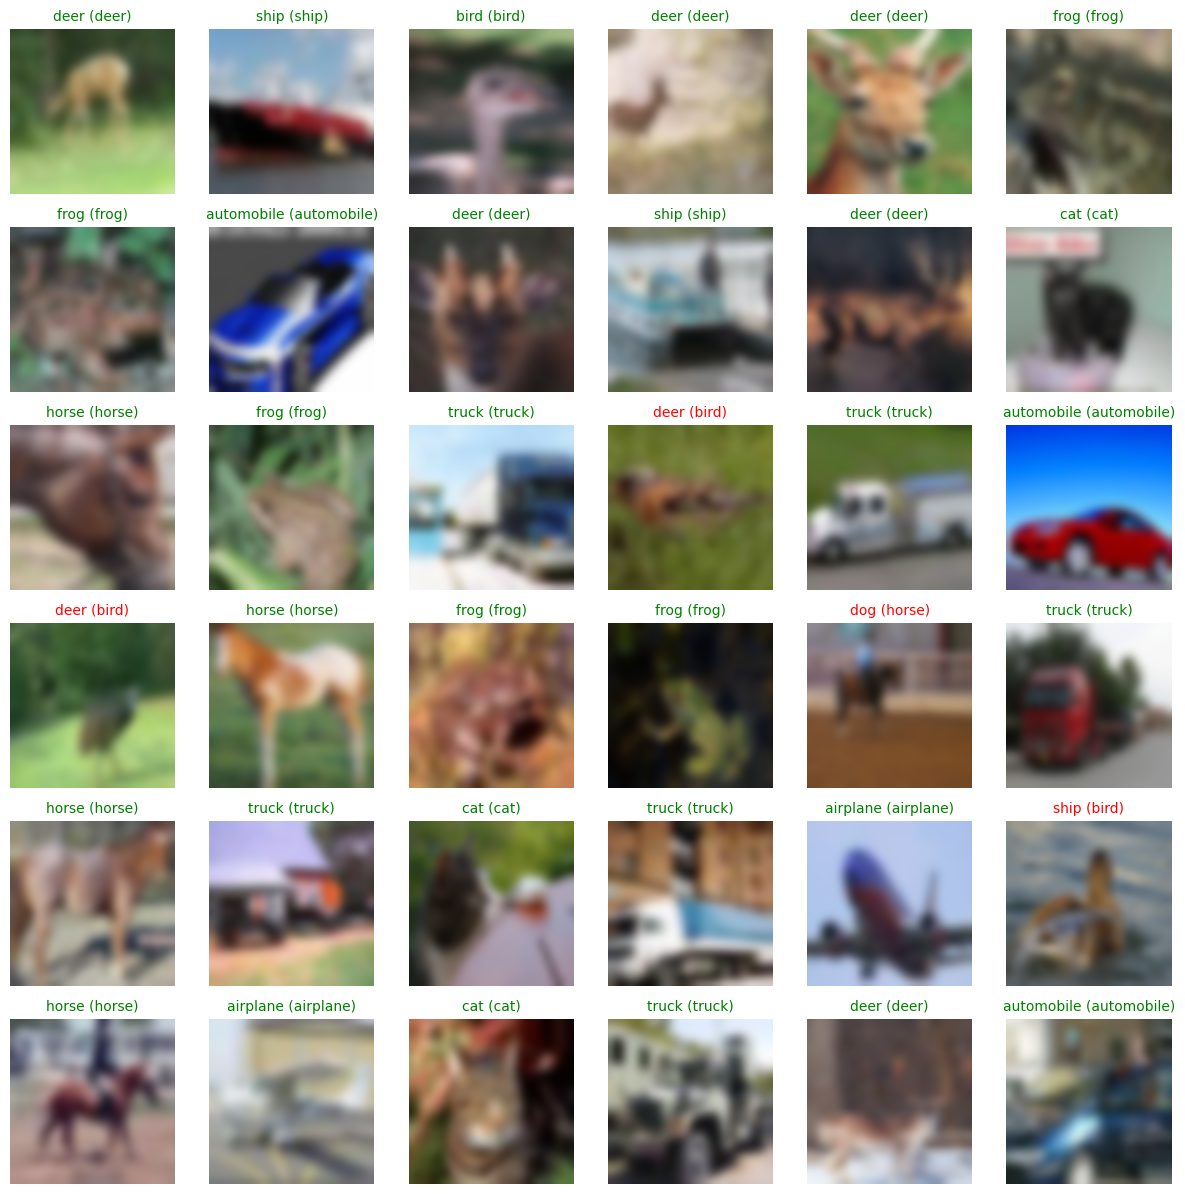

In [22]:
# This code creates a subset of test data with 36 random samples.
# It then creates a data loader for this subset with batch size 1 and shuffle set to False.
# Finally, it plots each sample in the subset along with its predicted class and actual class.

subset_indices = [np.random.randint(0, len(test_data.data)) for _ in range(36)]
subset = torch.utils.data.Subset(test_data, subset_indices)
testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)


fig = plt.figure(figsize=(15, 15))
for ind, (data, label) in enumerate(testloader_subset, start=1):
    fig.add_subplot(6, 6, ind)
    plt.axis("off")
    t_inv = transforms.Normalize(
        [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        [1 / 0.229, 1 / 0.224, 1 / 0.225],
    )
    re_inv = transforms.Resize(size=32, antialias=True)
    plt.imshow(re_inv(t_inv(data)).squeeze().permute(1, 2, 0), interpolation="bicubic")
    actual = test_data.classes[label]
    pred = test_data.classes[model.predict(data)]
    plt.title(
        f"{pred} ({actual})", fontsize=10, color="green" if actual == pred else "red"
    )